In [10]:
import numpy as np
import numpy.fft as nf
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as sc
import time as time

I2 = qt.qeye(2)
Na = 3
Ia = qt.qeye(Na)

sm = qt.tensor(Ia, qt.sigmam())
sx = qt.tensor(Ia, qt.sigmax())
sz = qt.tensor(Ia, qt.sigmaz())
a  = qt.tensor(qt.destroy(Na), I2)
II = qt.tensor(Ia, I2)

vac = qt.tensor(qt.basis(Na,0), qt.basis(2,1))

def state(n, gnd_or_exc):
    if gnd_or_exc is 'exc':
        psi = a.dag()*vac
    elif gnd_or_exc is 'gnd':
        psi = vac
    else:
        raise ValueError('Poor state definition')
    for ii in range(n):
        psi = a.dag()*psi
    return psi

options = qt.Options()
options.nsetps = 10000


class system(object):

    def __init__(self, w_qubit=6e3, g=1e-1, gamma=5e0, kappa=5e0, e_drive=2e0, **kwargs):
        
        self.args = {'w_qubit': w_qubit,
                     'w_cav'  : w_qubit,
                     'g'      : g,
                     'gamma'  : gamma,
                     'kappa'  : kappa,
                     'w_pump' : 2*w_qubit,
                     'e_pump' : 0,
                     'w_drive': w_qubit,
                     'e_drive': e_drive,
                     **kwargs}
        self.driv = {}         # filled when calling time_gen
        self.operators = {}    # filled when calling Dynamics
        
        self._compute()
        for keys in self.args.keys():
            self.args[keys] = 2*np.pi*self.args[keys]
    
            
    def _compute(self):
        
        self.args['d_cp'] = self.args['w_cav'] - self.args['w_pump']/2
        self.args['d_qp'] = self.args['w_qubit'] - self.args['w_qubit']/2

    def twopi_update(self, dic):
        
        for keys in dic.keys():
            dic[keys] *= 2*np.pi
        self.args.update(dic)
        self._compute()
        
    def freqs(self, key):
        
        return self.args[key]/2/np.pi
            
    def print_args(self, where):

        if where is 'inline':
            largs = {'w_qubit':'wq', 'w_cav':'wc', 'g':'g',
                     'gamma':'gamma', 'kappa':'kappa',
                     'w_pump':'wp', 'e_pump':'ep',
                     'w_drive':'wd', 'e_drive':'ed',
                     'd_cp':'dcp', 'd_qp':'dqp'}
        elif where is 'plot':
            largs = {'w_qubit':r'$\omega_q$', 'w_cav':r'$\omega_c$', 'g':r'$g$',
                     'gamma':r'$\gamma$', 'kappa':r'$\kappa$',
                     'w_pump':r'$\omega_p$', 'e_pump':r'$\varepsilon_p$',
                     'w_drive':r'$\omega_d$', 'e_drive':r'$\varepsilon_d$',
                     'd_cp':r'$\delta_{c-p}$', 'd_qp':r'$\delta_{q-p}$'}
        title = ''
        for keys in self.args.keys():
            val = self.args[keys]/2/np.pi
            title += largs[keys]+'=%.1f,  '%val
        return title[:-3]      
        
    def w_larmor(self):
        ''' Larmor frequency '''
        ''' Must be called after time_gen '''
        ''' w_drive is a np.array() '''
        ed = self.driv['e_drive']
        wq = self.args['w_qubit']
        wd = self.driv['w_drive']
        return np.sqrt(ed**2+(wq-wd)**2)

    def p_rabi(self):
        ''' Maximum excited probability for dissipation-less system '''
        ''' Must be called after time_gen '''
        ''' w_drive is a np.array() '''
        ed = self.driv['e_drive']
        wq = self.args['w_qubit']
        wd = self.driv['w_drive']
        return (ed/w_larmor(args))**2

    def Purcell(self):
        ''' Purcell broadening '''
        k  = self.args['kappa']
        g  = self.args['g']
        wq = self.args['w_qubit']
        wc = self.args['w_cav']
        return k*g**2/(k**2/4+(wq-wc)**2)

    def r_param(self):
        ''' r param in Leroux '''
        la = self.args['e_pump']
        dc = self.args['d_cp']
        return (1/2)*np.arctanh(la/dc)

    def Omega(self):
        ''' Omega in Leroux '''
        dc = self.args['d_cp']
        r  = self.r_param()
        return dc/np.cosh(r) 
    
    def Leroux(self, dpump, SdB):
        ''' Leroux resonant setup '''
        dpump *= 2*np.pi
        self.args['w_pump'] = 2*self.args['w_cav'] - 2*dpump
        self._compute()
        self.args['e_pump'] = dpump*np.tanh(np.log(10*np.log10(SdB)))
        self.args['w_qubit']= self.args['w_cav'] + self.Omega()


    def Dynamics(self, Htype, isD=True):
        
        def H1_coeff(t, args=self.args):
            ''' Cosine drive '''
            ''' (1/2) mimicks an exp(1j*w*t) drive in the spin locked frame '''
            return (1/2)*args['e_drive']*np.cos(args['w_drive']*t)
        
        def H2_coeff(t, args=self.args):
            ''' Cosine drive '''
            ''' (-1) mimicks an (-1/2)*exp(1j*w*t) drive in the spin locked frame '''
            return (-1)*args['e_pump']*np.cos(args['w_pump']*t)
        
        def D0_coeff(t, args=self.args):
            ''' Qubit relaxation '''
            return np.sqrt(args['gamma'])

        def Da_coeff(t, args=self.args):
            ''' Cav relaxation '''
            return np.sqrt(args['kappa'])

        if Htype is 'TLS':
            ''' '''
            H0 = self.args['w_qubit']*sz/2
            H1 = sx
            H  = [H0,[H1,H1_coeff]]
            
        elif Htype is 'Rabi':
            ''' '''
            H0 = self.args['w_qubit']*sz/2
            Ha = self.args['w_cav']*a.dag()*a
            Hc = self.args['g']*(a+a.dag())*sx
            H1 = a+a.dag()
            H  = [H0+Ha+Hc,[H1,H1_coeff]]
            
        elif Htype is 'JC':
            ''' Well-known Jesus-Christ Hamiltonian '''
            H0 = self.args['w_qubit']*sz/2
            Ha = self.args['w_cav']*a.dag()*a
            Hc = self.args['g']*(a*sm.dag()+a.dag()*sm)
            H1 = a+a.dag()
            H  = [H0+Ha+Hc,[H1,H1_coeff]]
            
        elif Htype is 'LRlab':
            ''' eqn (S8) '''
            H0 = self.args['w_qubit']*sz/2
            Ha = self.args['w_cav']*a.dag()*a
            Hc = self.args['g']*(a*sm.dag()+a.dag()*sm)
            H1 = a+a.dag()
            H2 = a**2+a.dag()**2
            H  = [H0+Ha+Hc,[H1,H1_coeff],[H2,H2_coeff]]
        
        elif Htype is 'LRrotated':
            ''' eqn (1) '''
            H0 = self.args['d_qp']*sz/2
            Ha = self.args['d_cp']*a.dag()*a
            Hc = self.args['g']*(a*sm.dag()+a.dag()*sm)
            Hp = (-1/2)*self.args['e_drive']*(a**2+a.dag()**2)
            H1 = a+a.dag()
            H  = [H0+Ha+Hc+Hp,[H1,H1_coeff]]
            
        elif Htype is 'LRsqueez':
            ''' eqn (3) '''
            H0 = self.args['d_qp']*sz/2
            Ha = self.Omega()*a.dag()*a
            Hc = (self.args['g']/2)*np.exp(self.r_param())*(a+a.dag())*sx
            HE = (-g/2)*np.exp(-self.r_param())*(a.dag()-a)*(sm.dag()-sm)
            HD = 0*II
            H1 = a+a.dag()
            H  = [H0+Ha+Hc+HE+HD,[H1,H1_coeff]]
        
        self.operators.update(H = H)
        
        if isD is True:
            D = [[sm, D0_coeff], [a, Da_coeff]]
            self.operators.update(D = D)
        else:
            self.operators.update(D = [])


#########################################
# Analysis
#########################################

def func_cos(x, w, phi, A, C):
    return A*np.cos(w*x+phi)+C

def fit_cos(x, y, printing=False):
    ''' Use Fourier Transform to feed initial values to cosine fit '''
    y_mean = np.mean(y)
    y_fft  = nf.rfft(y-y_mean, norm='ortho')
    freqs  = nf.rfftfreq(len(x), x[1]-x[0])
    i_gues = np.argmax(np.abs(y_fft))
    w_gues = 2*np.pi*freqs[i_gues]
    p_gues = np.pi*(1-np.sign(np.real(y_fft[i_gues])))/2
    A_gues = (np.max(y) - np.min(y))/2
    p0     = [w_gues, p_gues, A_gues, y_mean]
    popt, pcov = sc.curve_fit(func_cos, x, y, p0=p0)
    if printing:
        print('guess: ', np.round(p0,3))
        print('fit:   ', np.round(popt,3))
        print('------------------------')
    return popt, pcov

def func_lor(x, x0, gamma, A):
    return A/(1+((x-x0)*2/gamma)**2)

def func_double_lor(x, x0, gamma, A, g):
    return A*(1/(1+((x-x0-g)*2/gamma)**2)+1/(1+((x-x0+g)*2/gamma)**2))


#########################################
# Absorption Spectrum
#########################################

def time_gen(sys, sp=3, N=11, nmax=5000):
    ''' Construction of the drive and time lists: '''
    ''' Crucially one must resolve the drive frequency according to Shannon criteria, '''
    ''' which sets 'tstep'. Ideally the slow dynamics should also be captured, which '''
    ''' sets 'tmax', but the number of points is limited to 'nmax' '''

    wq = sys.args['w_qubit']
    ga = sys.args['gamma']
    ed = sys.args['e_drive']
    g  = sys.args['g']
    gp = sys.Purcell()
#    ge = g*np.exp(sys.r_param())

    if ga < ed:
        print('Time list generator: expect Power Broadening')

    wspan = max(ga, ed, g)*sp
    wslow = ga

    wdriv = np.linspace(wq-wspan, wq+wspan, N)
    tstep = 2*np.pi/(2*wdriv[-1])
    tmax  = 2*np.pi/wslow
    nopt  = 2*int(tmax/tstep)
    n     = min(nopt, nmax)
    times = np.linspace(0, n*tstep, n+1)

    sys.driv = {}
    sys.driv['w_drive'] = wdriv
    sys.driv['tstep']   = tstep
    sys.driv['tmax']    = tmax
    sys.driv['nopt']    = nopt
    sys.driv['n']       = n
    sys.driv['times']   = times

    return times

def absorption_spectrum(sys, N=11, sp=3, nmax=5000, printing=False):
    ''' Generate the absorption spectrum of the Qubit for N drives '''
    ''' centered around w_qubit with span +/- sp*gamma '''
    
    H    = sys.operators['H']
    psi0 = vac
    D    = sys.operators['D']
    obs  = [sm*sm.dag()]
    
    times = time_gen(sys, N=N, sp=sp, nmax=nmax)
    freqs = nf.rfftfreq(len(times), times[1]-times[0])
    
    alert = 0
    if sys.driv['n'] is nmax:
        alert = 1
    print(sys.driv['n'], 'bins:', end='')
    start = time.time()
    
    s_abs = np.zeros(N)
    for ii, wd in enumerate(sys.driv['w_drive']):
        startloop = time.time()
        sys.args.update({'w_drive':wd})
        result    = qt.mesolve(H, psi0, times, D, obs, args=sys.args, options=options)  
        smsp_fft  = nf.rfft(result.expect[0], norm='ortho')
        ii_wd     = np.argmin(np.abs(freqs-wd/2/np.pi))
        s_abs[ii] = np.abs(smsp_fft[ii_wd])
        
        if printing and ii in [int(N/4), int(N/2)]:
            fig, ax = plt.subplots(1,2, figsize=(12,4))
            ax[0].plot(times, result.expect[0])
            ax[0].set_ylabel(r'$<\sigma_-\sigma_+>$')
            ax[0].grid(linestyle='--')
            ax[1].plot(freqs[:], np.abs(smsp_fft[:]))
            ax[1].plot(freqs[ii_wd], np.abs(smsp_fft[ii_wd]), 'o')
            ax[1].set_ylabel(r'|TF $[<\sigma_-\sigma_+>]$|')
            ax[1].grid(linestyle='--')
            ax[1].set_ylim([np.abs(smsp_fft[ii_wd])*(-0.1),np.abs(smsp_fft[ii_wd])*20])
#            title = r'$\omega_d=$%.2f, $\varepsilon_d=$%.2f'%(wd/2/np.pi, edrive)
            fig.suptitle(sys.print_args('plot'))

    if alert:
        print(' ', np.round(time.time()-start,1),'s - nmax reached ', str(sys.driv['nopt']))
    else:
        print(' ', np.round(time.time()-start,1),'s')
            
    return sys.driv['w_drive'], s_abs


#########################################
# Eigenspectrum
#########################################

def eigenspectrum(sys, Htype, sweep_key, sweep_key_list):
    
    nrj_list, state_list = [], []
    for ii, kk in enumerate(sweep_key_list):
        args = sys.twopi_update({sweep_key:kk})
        sys.Dynamics(Htype, isD=False)
        Ham = sys.operators['H'][0]
        nrj, state = Ham.eigenstates()
        nrj_list.append(nrj)
        state_list.append(state)
    nrj_list   = np.array(nrj_list).T/2/np.pi
    state_list = np.array(state_list).T
    
    return nrj_list, state_list

#[, '_classic_test_patch', 'seaborn', 'seaborn-colorblind', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
#plt.style.use('seaborn-white')
#plt.rcdefaults()

4884 bins:  332.0 s
done


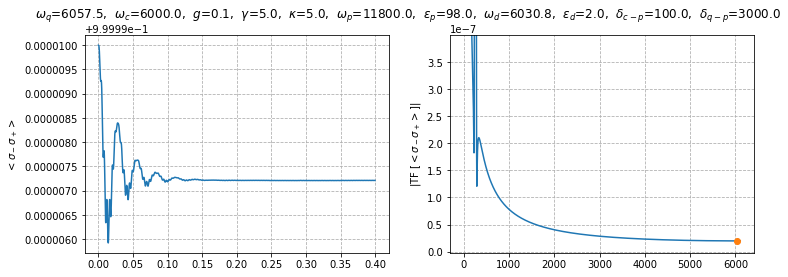

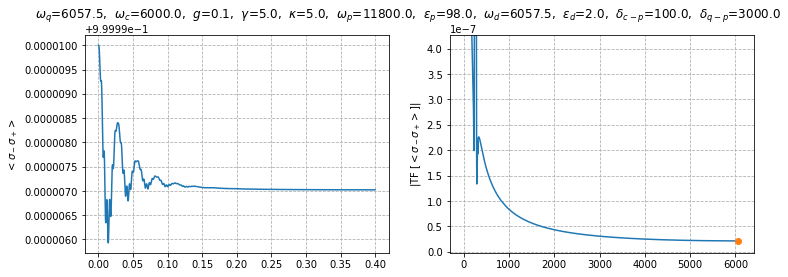

In [25]:
''' Figure 1 '''
sys = system(g=0.1)
#print(sys.print_args('inline'))
S_list = np.array([10])
w_drive_list, s_abs_list = [], []
for ii, S in enumerate(S_list):
    sys.Leroux(dpump=1e2, SdB=S)
    sys.Dynamics(Htype='LRlab', isD=True)
    w_drive, s_abs = absorption_spectrum(sys, sp=10, N=31, printing=True)
    w_drive_list.append(w_drive)
    s_abs_list.append(s_abs)
print('done')

[6.08624394e+03 5.00000000e+00 1.59154943e-01 3.16227766e-01]
[ 6.09877040e+03  2.56707879e+02  1.11936520e-01 -9.32704283e+01]


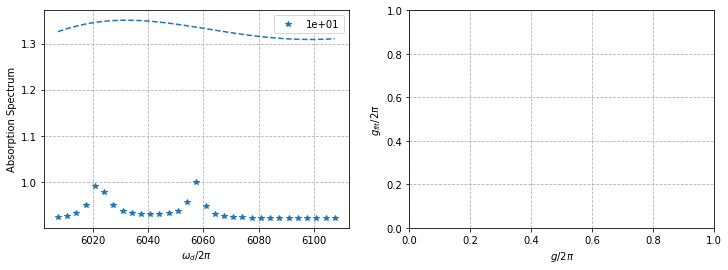

In [51]:
''' Plotting '''
fig, ax = plt.subplots(1,2, figsize=(12,4))
for ii, S in enumerate(S_list):
    sys.Leroux(dpump=1e2, SdB=S)
    wdriv = w_drive_list[ii]
    s_abs = s_abs_list[ii]/np.max(s_abs_list[ii])
    p0 = [sys.args['w_qubit']+sys.Omega()/2,sys.args['gamma'],1,sys.args['g']*np.exp(sys.r_param())]
    popt, pcov = sc.curve_fit(func_double_lor, wdriv, s_abs, p0=p0)
    wdriv_th = np.linspace(wdriv[0], wdriv[-1], 101)
    ax[0].plot(wdriv/2/np.pi, s_abs, '*', label='%.g'%(S), color='C'+str(ii))
    ax[0].plot(wdriv_th/2/np.pi, func_double_lor(wdriv_th,*popt)/popt[2], '--', color='C'+str(ii))
#    ax[1].plot(g, popt[3]/2/np.pi, '+')
print(np.array(p0)/2/np.pi)
print(np.array(popt)/2/np.pi)
ax[0].set_ylabel(r'Absorption Spectrum')
ax[0].grid(linestyle='--')
ax[0].set_xlabel(r'$\omega_d/2\pi$')
ax[0].legend()
ax[1].set_ylabel(r'$g_{fit}/2\pi$')
ax[1].grid(linestyle='--')
ax[1].set_xlabel(r'$g/2\pi$')
plt.show()

In [52]:
sys.argsg*np.exp(sys.r_param())

10

4812 bins:  244.2 s
4812 bins:  180.5 s
4824 bins:  173.9 s


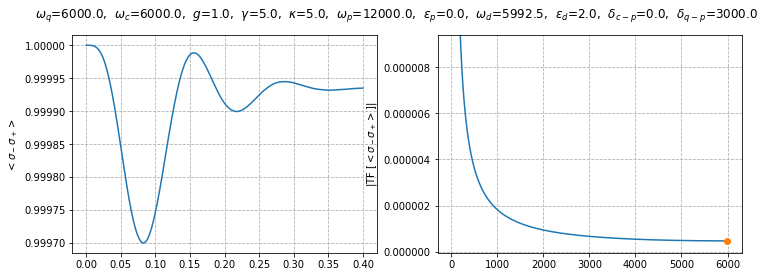

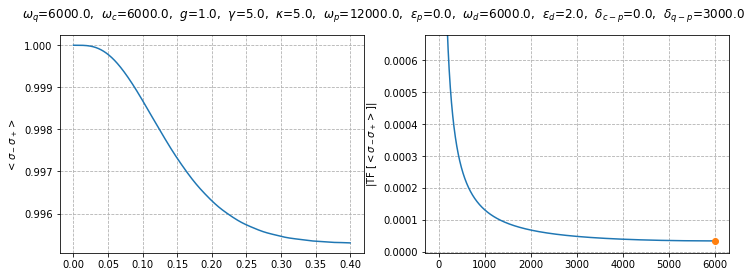

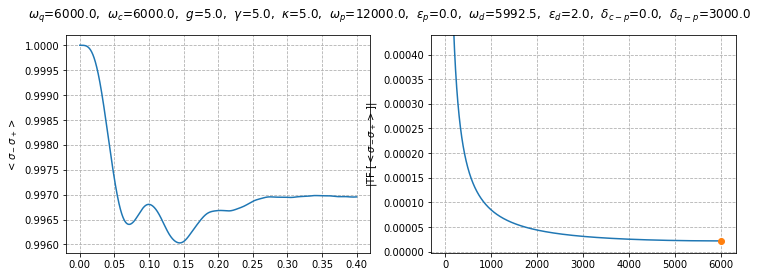

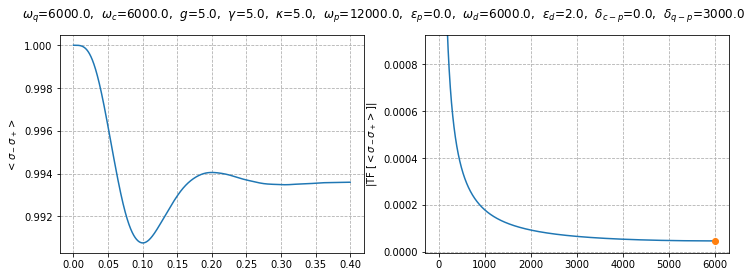

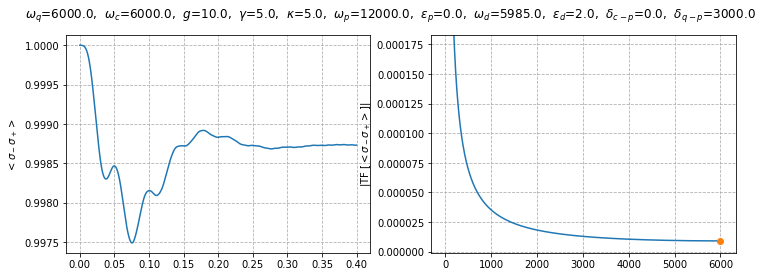

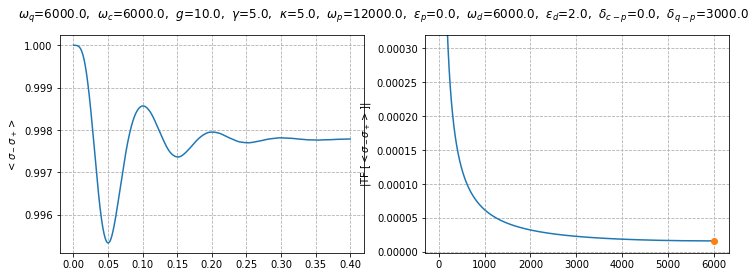

In [11]:
''' Vacuum Rabi Splitting   '''
sys = system()
#print(sys.print_args('inline'))
g_list = np.array([1,5,10])
w_drive_list, s_abs_list = [], []
for ii, g in enumerate(g_list):
    sys.twopi_update({'g':g})
    sys.Dynamics(Htype='Rabi', isD=True)
    w_drive, s_abs = absorption_spectrum(sys, sp=3, N=21, printing=True)
    w_drive_list.append(w_drive)
    s_abs_list.append(s_abs)

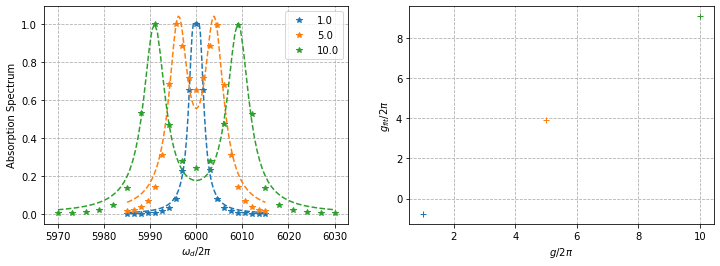

In [21]:
''' Plotting VRS '''
fig, ax = plt.subplots(1,2, figsize=(12,4))
for ii, g in enumerate(g_list[:]):
    wdriv = w_drive_list[ii]
    s_abs = s_abs_list[ii]/np.max(s_abs_list[ii])
    popt, pcov = sc.curve_fit(func_double_lor, wdriv, s_abs,
                              p0=[sys.args['w_qubit'],sys.args['gamma'],1,g])
    wdriv_th = np.linspace(wdriv[0], wdriv[-1], 101)
    ax[0].plot(wdriv/2/np.pi, s_abs, '*', label='%.1f'%(g), color='C'+str(ii))
    ax[0].plot(wdriv_th/2/np.pi, func_double_lor(wdriv_th,*popt), '--', color='C'+str(ii))
    ax[1].plot(g, popt[3]/2/np.pi, '+')
#    ax[1].plot(np.linspace(0,10), np.linspace(0,10), '--')
ax[0].set_ylabel(r'Absorption Spectrum')
ax[0].grid(linestyle='--')
ax[0].set_xlabel(r'$\omega_d/2\pi$')
ax[0].legend()
ax[1].set_ylabel(r'$g_{fit}/2\pi$')
ax[1].grid(linestyle='--')
ax[1].set_xlabel(r'$g/2\pi$')
plt.show()

done


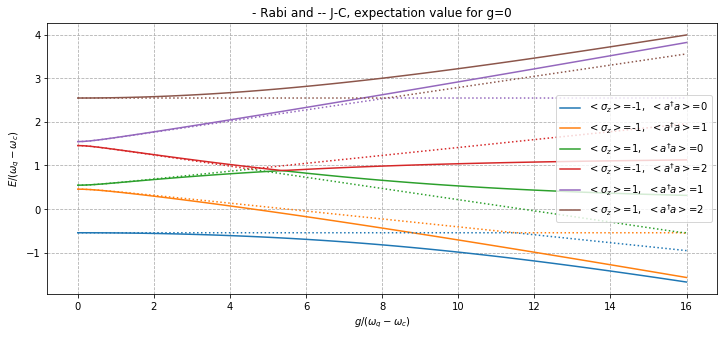

In [4]:
''' Spectrum vs g '''
sys = system(w_qubit=6e3,w_cav=5.5e3)
g_list = np.linspace(1,8000,100)
nrj_list, state_list = eigenspectrum(sys, 'Rabi', 'g', g_list)
nrj_rwa_list, state_rwa_list = eigenspectrum(sys, 'JC', 'g', g_list)
print('done')

''' Plotting '''
Nst   = 6
xscal = sys.freqs('w_qubit')-sys.freqs('w_cav')
yscal = sys.freqs('w_cav')
xaxis = g_list/xscal
ex_sz = [qt.expect(sz ,state_list[ii][0]) for ii in range(Nst)]
ex_aa = [qt.expect(a.dag()*a ,state_list[ii][0]) for ii in range(Nst)]
label = [r'$<\sigma_z>$=%.0f,  $<a^\dag a>$=%.0f'%(ex_sz[ii],ex_aa[ii]) for ii in range(Nst)]
fig, ax = plt.subplots(figsize=(12,5))
[ax.plot(xaxis, nrj_list[ii]/yscal, color='C'+str(ii), label=label[ii]) for ii in range(Nst)]
[ax.plot(xaxis, nrj_rwa_list[ii]/yscal, ':', color='C'+str(ii)) for ii in range(Nst)]
#ax.axvline(1, c='k')
#ax.axvline(sys.args['w_qubit']/xscal, c='k')
#ax[0].set_xlim([-100,1000])
ax.set_xlabel(r'$g / (\omega_q-\omega_c)$')
ax.set_ylabel(r'$E / (\omega_q-\omega_c)$')
ax.set_title(r'- Rabi and -- J-C, expectation value for g=0')
ax.grid(linestyle='--')
ax.legend()

plt.show()

wq=6000.0,  wc=6000.0,  g=1.0,  gamma=5.0,  kappa=5.0,  wp=12000.0,  ep=0.0,  wd=6000.0,  ed=2.0,  dcp=0.0,  dqp=3000.0


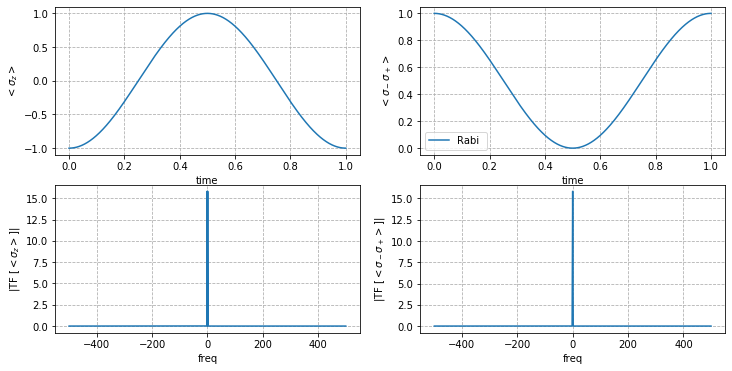

In [5]:
''' Time and frequency visualisation '''

sys = system(w_qubit=6e3, g=1e0, e_drive=2)
print(sys.print_args('inline'))
sys.Dynamics(Htype='TLS', isD=False)

H     = sys.operators['H']
psi0  = vac
times = np.linspace(0,1,1001)
D     = sys.operators['D']
obs   = [sz, sm*sm.dag()]
args  = sys.args

result = qt.mesolve(H, psi0, times, D, obs, args=args, options=options)

sz_fft   = nf.fftshift(nf.fft(result.expect[0], norm='ortho'))
smsp_fft = nf.fftshift(nf.fft(result.expect[1], norm='ortho'))
freqs    = nf.fftshift(nf.fftfreq(len(times), times[1]-times[0]))


fig, ax = plt.subplots(2,2, figsize=(12,6))
ax[0,0].plot(times, result.expect[0], '-')
ax[0,0].set_ylabel(r'$<\sigma_z>$')
ax[0,0].grid(linestyle='--')
ax[0,0].set_xlabel('time')
ax[1,0].plot(freqs, np.abs(sz_fft))
ax[1,0].set_ylabel(r'|TF $[<\sigma_z>]$|')
ax[1,0].set_xlabel('freq')
ax[1,0].grid(linestyle='--')
ax[0,1].plot(times, result.expect[1], label='Rabi ')
ax[0,1].legend()
ax[0,1].set_ylabel(r'$<\sigma_-\sigma_+>$')
ax[0,1].grid(linestyle='--')
ax[0,1].set_xlabel('time')
ax[1,1].plot(freqs[:], np.abs(smsp_fft[:]), label='Rabi ')
ax[1,1].set_ylabel(r'|TF $[<\sigma_-\sigma_+>]$|')
ax[1,1].set_xlabel('freq')
ax[1,1].grid(linestyle='--')
#ax[1,1].set_ylim([0,0.2])


